In [3]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut
import bayesian as bay

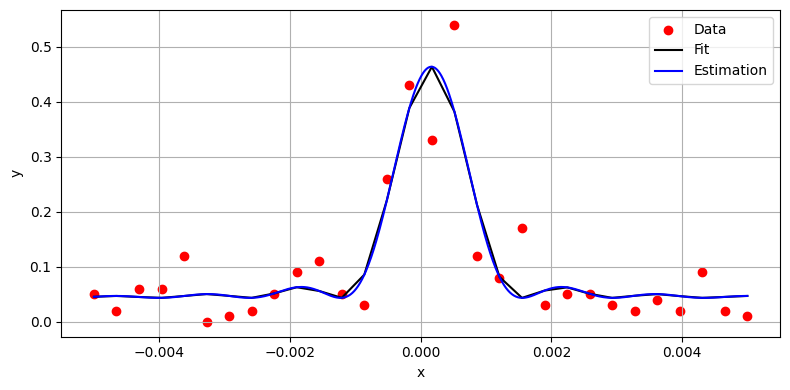

In [149]:
import numpy as np
import json
import matplotlib.pyplot as plt
from lmfit import Model

def sinc(x, a, b, c, d):
    sinc_term = np.sinc(b * (x-d) / np.pi) ** 2  # sinc(x) = sin(pi*x)/(pi*x)
    return c * sinc_term + a

max_frequency_mhz = 0.005
scan_points = 1000

freq = np.linspace(-max_frequency_mhz, max_frequency_mhz, scan_points)



dfile = json.load(open('/home/sdruci/QIC/QIC/project/odf_json/18_10_19_074236.json'))
data = np.array(dfile['data']['mean_excitation']['values'])

x_data = data[:, 1]  # Asse x (frequenze)
y_data = data[:, 0]  # Asse y (misure di eccitazione)

model = Model(sinc)

params = model.make_params(
    a=0.0455,   # Offset iniziale
    b=2263.33,   # Frequenza caratteristica iniziale
    c=0.4067,  # Ampiezza del picco iniziale
    d =0.001
)

result = model.fit(y_data, params, x=x_data)

y_estimated = sinc(freq, **result.best_values)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x_data, y_data, color='red', label='Data')
ax.plot(x_data, sinc(x_data, **result.best_values), color='black', label='Fit')
ax.plot(freq, y_estimated, color='blue', label='Estimation')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [133]:
import numpy as np
import json
import matplotlib.pyplot as plt
from lmfit import Model

# Definizione della funzione sinc per il fit
def sinc(x, a, b, c, d):
    sinc_term = np.sinc(b * (x-d) / np.pi) ** 2  # sinc(x) = sin(pi*x)/(pi*x)
    return c * sinc_term + a

# Funzione principale per il fit
def odf(freq):

    # Carica i dati sperimentali dal file JSON
    dfile = json.load(open('/home/sdruci/QIC/QIC/project/odf_json/18_10_19_074236.json'))
    data = np.array(dfile['data']['mean_excitation']['values'])

    x_data = data[:, 1]  # Asse x (frequenze)
    y_data = data[:, 0]  # Asse y (misure di eccitazione)

    # Crea il modello di lmfit basato sulla funzione sinc
    model = Model(sinc)

    # Inizializzazione dei parametri per il fit
    params = model.make_params(
        a=0.0455,   # Offset iniziale
        b=2263.33,   # Frequenza caratteristica iniziale
        c=0.4067,  # Ampiezza del picco iniziale
        d =0.001
    )

    # a=0.0455, b=2263.33, c=0.4067

    # Imposta solo limiti minimi (se necessario)
    # params['b'].min = 1000  # Imposta un limite inferiore per b, ma non un massimo
    # params['c'].min = 0     # Assicura che c sia positivo

    # Esegue il fit
    result = model.fit(y_data, params, x=x_data)

    # Stampa il report del fit
    # print(result.fit_report())

    # Calcola la stima per i valori richiesti
    y_estimated = sinc(freq, **result.best_values)

    # Calcola i residui e l'errore RMSE
    residuals = y_data - result.best_fit
    rmse = np.sqrt(np.mean(residuals**2))
    # print(f"Errore quadratico medio (RMSE): {rmse:.6f}")

    return y_estimated


duration_us=1000; rabi_rate_mhz=2 $\pi$ 0.001

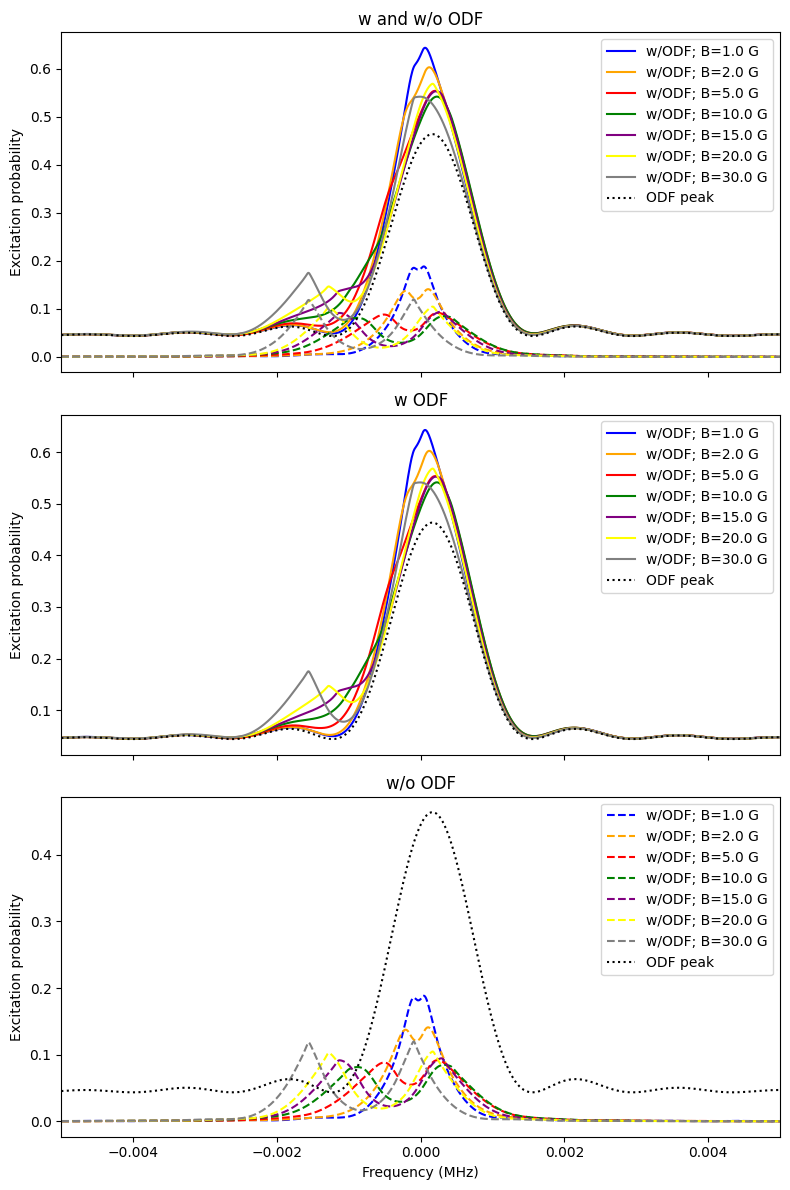

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei parametri
j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2 * np.pi * 0.001,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]
colors = ["blue", "orange", "red", "green", "purple", "yellow", "gray"]

# Creiamo i 3 subplot
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    # Simulazione dei falsi positivi ODF
    odf_false_positive = odf(frequencies)

    # Spettro aggiornato con ODF
    exc_probs_odf = exc_probs + odf_false_positive

    # Primo subplot: tutte le curve
    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--')  # Linea tratteggiata

    # Secondo subplot: solo exc_probs_odf
    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    # Terzo subplot: solo exc_probs
    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")

# Impostazioni degli assi
for ax in axs:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()
plt.show()


duration_us=5000; rabi_rate_mhz=2 $\pi$ 0.001

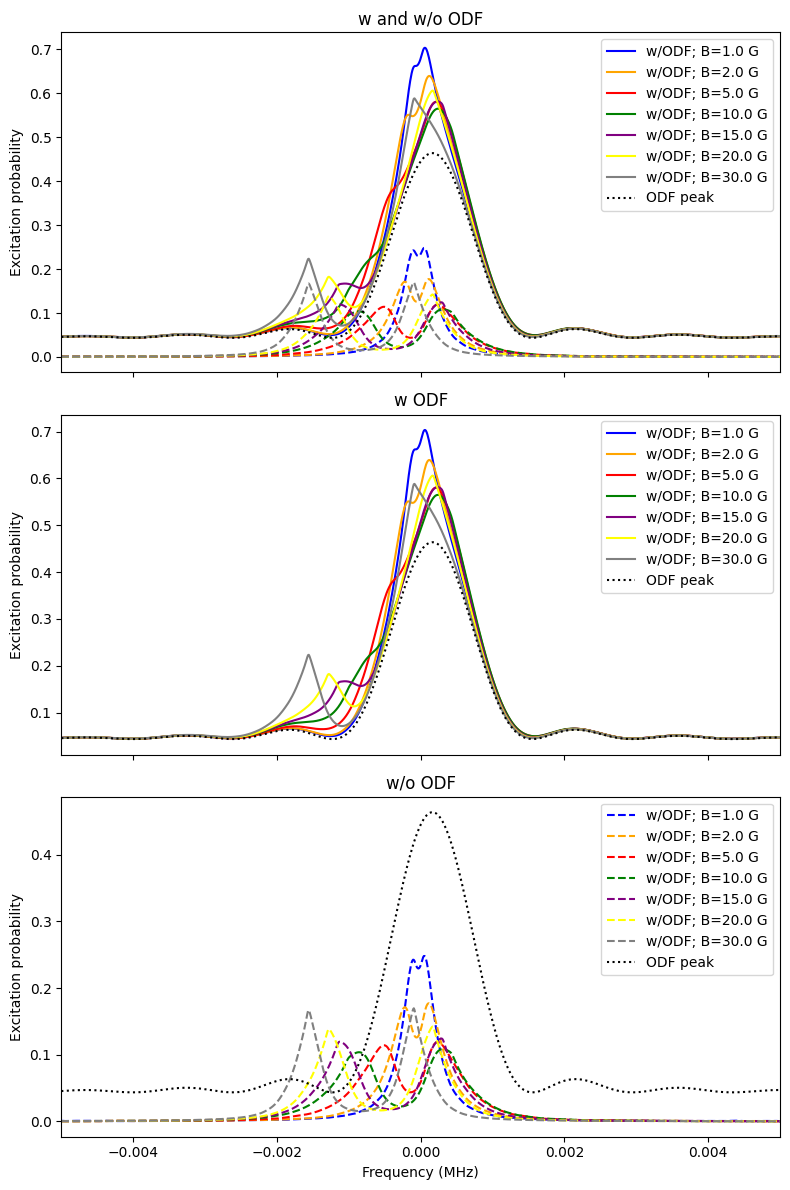

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei parametri
j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 5000,
    'rabi_rate_mhz': 2 * np.pi * 0.001,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]
colors = ["blue", "orange", "red", "green", "purple", "yellow", "gray"]

# Creiamo i 3 subplot
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    # Simulazione dei falsi positivi ODF
    odf_false_positive = odf(frequencies)

    # Spettro aggiornato con ODF
    exc_probs_odf = exc_probs + odf_false_positive

    # Primo subplot: tutte le curve
    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--')  # Linea tratteggiata

    # Secondo subplot: solo exc_probs_odf
    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    # Terzo subplot: solo exc_probs
    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")

# Impostazioni degli assi
for ax in axs:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()
plt.show()


duration_us=1000; rabi_rate_mhz=2 $\pi$ 0.005

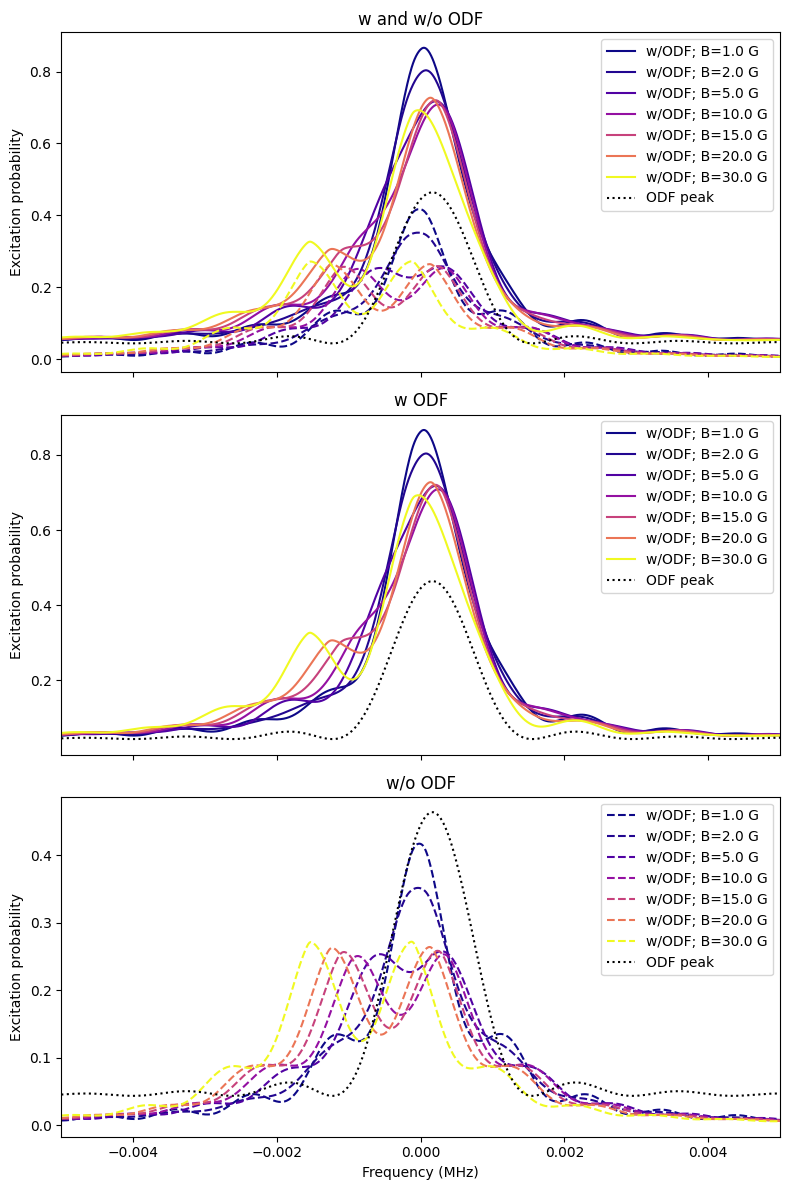

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei parametri
j_max = 50
temperature = 300

spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2 * np.pi * 0.005,
    'max_frequency_mhz': 0.005,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': 1600,
    'is_minus': True
}

b_field_gauss = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0]

cmap = plt.get_cmap("plasma")  # Cambia "plasma" con "viridis", "coolwarm", ecc. per provare altri colori
norm = plt.Normalize(vmin=min(b_field_gauss), vmax=max(b_field_gauss))
colors = [cmap(norm(b)) for b in b_field_gauss]

# Creiamo i 3 subplot
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for b, color in zip(b_field_gauss, colors):
    mo1 = CaOH.create_molecule_data(b_field_gauss=b, j_max=j_max)
    states1 = qls.States(mo1, temperature)

    frequencies, exc_probs = qls.get_spectrum(
        molecule=mo1,
        state_distribution=mo1.state_df["state_dist"],
        **spectrum_list,
        noise_params=None,
        seed=None
    )

    # Simulazione dei falsi positivi ODF
    odf_false_positive = odf(frequencies)

    # Spettro aggiornato con ODF
    exc_probs_odf = exc_probs + odf_false_positive

    # Primo subplot: tutte le curve
    axs[0].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")
    axs[0].plot(frequencies, exc_probs, color=color, linestyle='--')  # Linea tratteggiata

    # Secondo subplot: solo exc_probs_odf
    axs[1].plot(frequencies, exc_probs_odf, color=color, linestyle='-', label=f"w/ODF; B={b} G")

    # Terzo subplot: solo exc_probs
    axs[2].plot(frequencies, exc_probs, color=color, linestyle='--', label=f"w/ODF; B={b} G")

# Impostazioni degli assi
for ax in axs:
    ax.set_xlim([-spectrum_list['max_frequency_mhz'], spectrum_list['max_frequency_mhz']])
    ax.set_ylabel("Excitation probability")

axs[0].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[1].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata
axs[2].plot(frequencies, odf_false_positive, color='black', linestyle=':', label='ODF peak')  # Linea puntinata

axs[0].set_title("w and w/o ODF")
axs[1].set_title("w ODF")
axs[2].set_title("w/o ODF")

axs[-1].set_xlabel("Frequency (MHz)")
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()
plt.show()


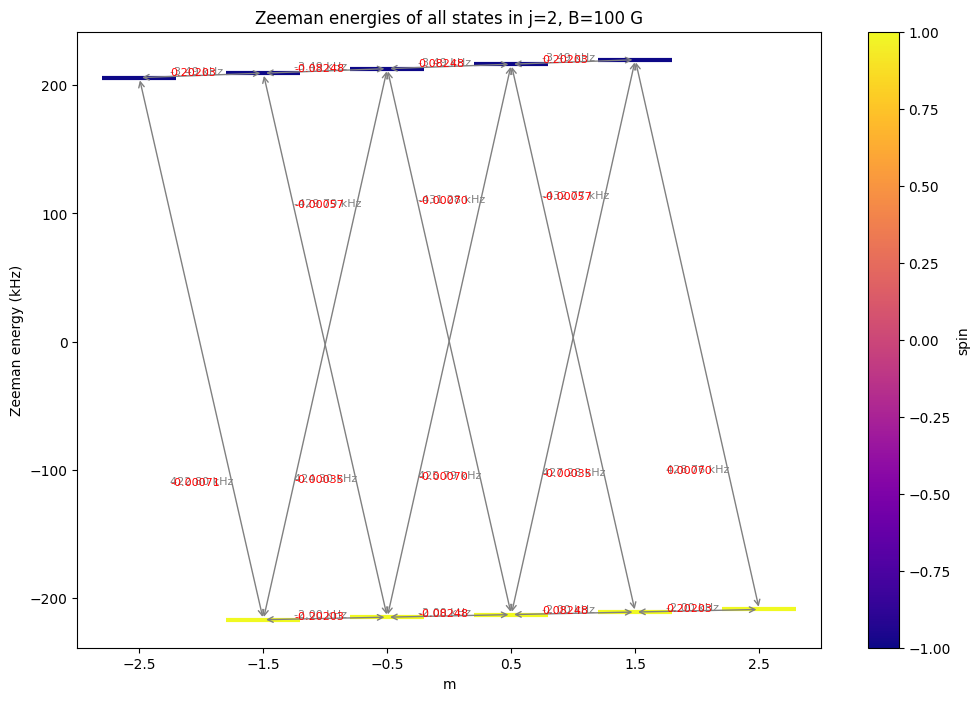

In [141]:
b_field_gauss = 100
j_max = 50

mo1 = CaOH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)


mo1.plot_zeeman_levels(2)